# Quantum Harmonic Oscillator (Continued)
#### Hunter Lybbert
#### Student ID 2426454
#### 11-01-24

In [152]:
import numpy as np
from scipy.sparse import diags, csr_matrix, dia_matrix
from scipy.integrate import solve_ivp
import scipy.linalg as la
from matplotlib import pyplot as plt

## Repeat HW 2

In [134]:
plt.rcParams['grid.linestyle'] = "--"

In [135]:
def my_ode(x: float, y: np.array, epsilon: float) -> np.array:
    return np.array([y[1], (x**2 - epsilon)*y[0]])

def target_bc_end(x:float, epsilon:float, y_0_end: float) -> float:
    return -np.sqrt(x**2 - epsilon)*y_0_end

In [136]:
def homework_two_process():
    """
    This encapsulates everything we did in hw two so we don't mess up any namespace weirdness.

    returns solutions A1 and A2
    """
    eigenvalues = []
    eigenvectors = []


    epsilon_initial = 1
    epsilon_diff = 0.1
    y_at_0 = 1
    xshoot = np.arange(-4, 4.1, 0.1)

    for mode in range(1, 6):

        epsilon_current = epsilon_initial
        epsilon_diff = 0.1

        for _ in range(1000):
            y0 = np.array([y_at_0, np.sqrt(4**2 - epsilon_current)])
            sol = solve_ivp(
                fun=my_ode,
                t_span=(-4, 4),
                y0=y0,
                method="RK45",
                args=(epsilon_current,),
                dense_output=True
            )

            boundary_value_diff = sol.y[1,-1] - target_bc_end(4, epsilon_current, sol.y[0, -1])

            if abs(boundary_value_diff) < 1e-6:
                print(epsilon_current)
                eigenvalues.append(epsilon_current)
                break
            
            elif (-1)**(mode + 1)*boundary_value_diff < 0:
                epsilon_current -= epsilon_diff
                epsilon_diff /= 2

            else:
                epsilon_current += epsilon_diff
                
        epsilon_initial = epsilon_current + 0.1

        eigenvector = sol.sol(xshoot)[0, :]
        trap_norm_of_eigenvector = np.trapezoid(eigenvector*eigenvector, xshoot)
        trap_normalized_eigenvector = eigenvector/np.sqrt(trap_norm_of_eigenvector)

        eigenvectors.append(trap_normalized_eigenvector)

        plt.plot(xshoot, trap_normalized_eigenvector, label=rf"$\lambda_{mode}$")
        plt.legend()
        plt.grid()

    plt.show()

    # The abdsolute value of the first 5 eigenfunctions, this should be (81,5)
    A1 = abs(np.vstack(eigenvectors).T)
    # The corresponding first 5 eigenvalues, this should be (1,5)
    A2 = np.array(eigenvalues)

    return A1, A2

0.9997357911453946
2.9990026018198495
4.9984630555462
6.99758100515118
8.99625425046196


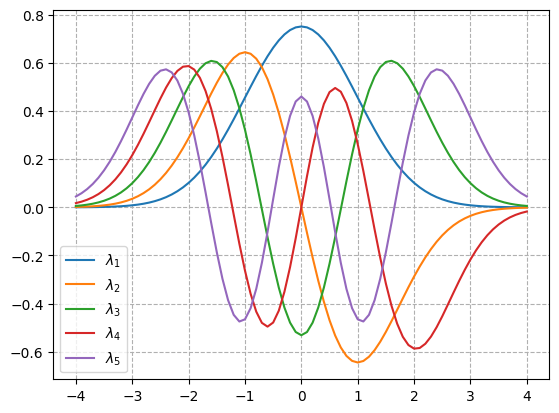

In [137]:
A1, A2 = homework_two_process()

## Actual HW 3
### b)

In [153]:
L = 4
step_size = 0.1

x = np.arange(
    start=-L,
    stop=L+step_size,
    step=step_size
)
N = x.size
diag_0 = -2*np.ones_like(x)
diag_1 = np.ones_like(x[1:N])
diag_minus_1 = np.ones_like(x[1:N])

A = diags([diag_0, diag_1, diag_minus_1], [0, 1, -1])

diff_matrix = A.toarray()

left_boundary = diff_matrix[0]
right_boundary = diff_matrix[-1]

forward_diff_left_boundary = np.zeros_like(left_boundary)
backward_diff_right_boundary = np.zeros_like(right_boundary)

forward_diff_left_boundary[:4] = np.array([2, -5, 4, -1])
backward_diff_right_boundary[-4:] = np.array([-1, 4, -5, 2])

diff_matrix[0] = forward_diff_left_boundary
diff_matrix[-1] = backward_diff_right_boundary

row = np.array([0, 0, 0, 80, 80, 80])
col = np.array([0, 1, 2, 78, 79, 80])
data = np.array([-1, 4/3, -1/3, -1/3, 4/3, -1])
C = csr_matrix((data, (row, col)), shape=(N, N)).toarray()

P = diags((x**2), 0)

Eigenvectors:
(81, 81)
Eigenvalues:
(81,)


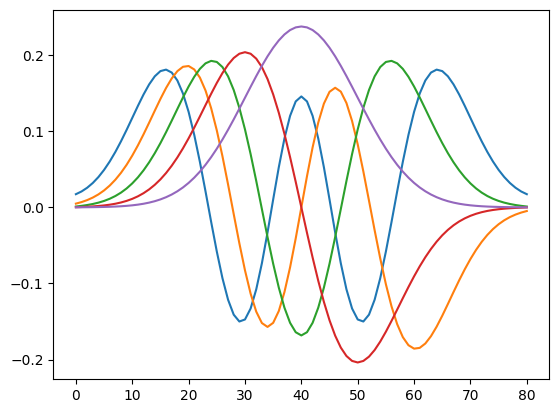

In [154]:
linL = (1/(step_size**2))*diff_matrix - P + C

eigenvalues, eigenvectors = la.eig(linL)

sorted_indices = np.argsort(np.abs(eigenvalues))[::-1] 
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[:,sorted_indices]


D5 = eigenvalues_sorted[N-5:N]
V5 = eigenvectors_sorted[:,N-5:N]

print("Eigenvectors:")
print(eigenvectors.shape)
print("Eigenvalues:")
print(eigenvalues.shape)

plt.plot(V5)

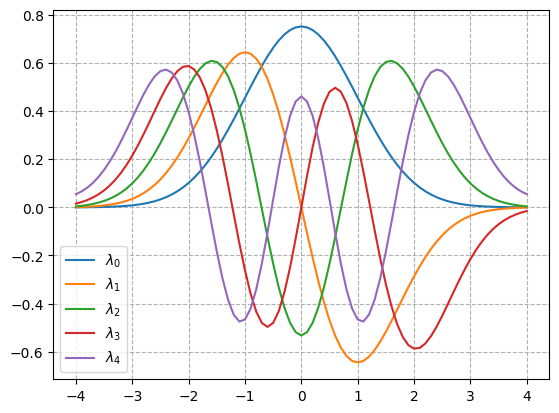

In [155]:
for j, eigenvector in enumerate(V5.T[::-1]):
    trap_norm_of_eigenvector = np.trapezoid(eigenvector*eigenvector, x)
    trap_normalized_eigenvector = eigenvector/np.sqrt(trap_norm_of_eigenvector)

    plt.plot(x, trap_normalized_eigenvector, label=rf"$\lambda_{j}$")
    plt.legend()
    plt.grid()

plt.show()

In [156]:
D5[::-1]

array([-0.99937553+0.j, -2.99689136+0.j, -4.99202128+0.j, -6.98461534+0.j,
       -8.96880444+0.j])

## Attempt 2

In [162]:
L = 4
step_size = 0.1

x = np.arange(
    start=-L,
    stop=L+step_size,
    step=step_size
)
N = x.size
diag_0 = -2*np.ones_like(x)
diag_1 = np.ones_like(x[1:N])
diag_minus_1 = np.ones_like(x[1:N])

A = diags([diag_0, diag_1, diag_minus_1], [0, 1, -1])

diff_matrix = A.toarray()[1:-1,1:-1]
diff_matrix.shape

(79, 79)

In [164]:
row = np.array([0, 0, N-3, N-3])
col = np.array([0, 1, N-4, N-3])
data = np.array([4/3, -1/3, -1/3, 4/3])
C = csr_matrix((data, (row, col)), shape=(N-2, N-2)).toarray()
C.shape

(79, 79)

In [165]:
P = diags((x[1:-1]**2), 0)
P.shape

(79, 79)

Eigenvectors:
(79, 79)
Eigenvalues:
(79,)


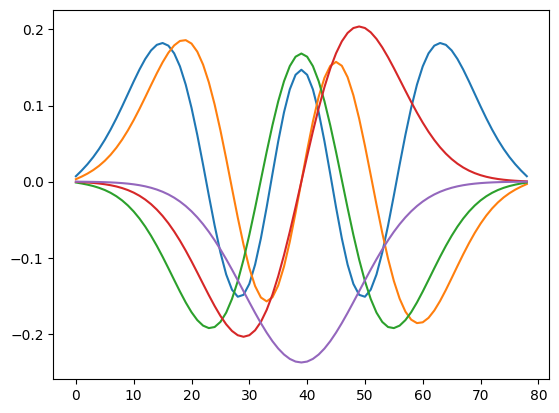

In [167]:
linL = -((1/(step_size**2))*diff_matrix - P + C)

eigenvalues, eigenvectors = la.eig(linL)

sorted_indices = np.argsort(np.abs(eigenvalues))[::-1] 
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[:,sorted_indices]


D5 = eigenvalues_sorted[-5:]
V5 = eigenvectors_sorted[:,-5:]

print("Eigenvectors:")
print(eigenvectors.shape)
print("Eigenvalues:")
print(eigenvalues.shape)

plt.plot(V5)

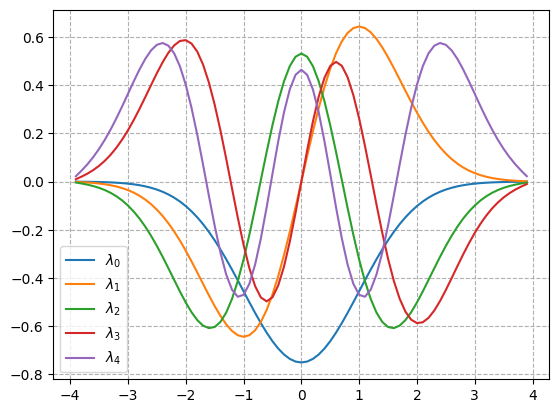

In [170]:
for j, eigenvector in enumerate(V5.T[::-1]):
    trap_norm_of_eigenvector = np.trapezoid(eigenvector*eigenvector, x[1:-1])
    trap_normalized_eigenvector = eigenvector/np.sqrt(trap_norm_of_eigenvector)

    plt.plot(x[1:-1], trap_normalized_eigenvector, label=rf"$\lambda_{j}$")
    plt.legend()
    plt.grid()

plt.show()

In [174]:
D5[::-1]

array([0.99937563+0.j, 2.99690123+0.j, 4.99226444+0.j, 6.98768156+0.j,
       8.99313582+0.j])